In [1]:
# from fiam
import datetime
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

print(datetime.datetime.now())

# turn off pandas Setting with Copy Warning
pd.set_option("mode.chained_assignment", None)

# set working directory
work_dir = "/content/"

# read sample data
file_path = os.path.join(
    work_dir, "hackathon_sample_v2.csv"
)  # replace with the correct file name
raw = pd.read_csv(
    file_path, low_memory=False, sep=';',parse_dates=["date"]
)  # the date is the first day of the return month (t+1)

# read list of predictors for stocks
file_path = os.path.join(
    work_dir, "factor_char_list.csv"
)  # replace with the correct file name
stock_vars = list(pd.read_csv(file_path)["variable"].values)

# define the left hand side variable
ret_var = "stock_exret" #possibly change?
new_set = raw[
    raw[ret_var].notna()
].copy()  # create a copy of the data and make sure the left hand side is not missing


2024-10-03 22:34:45.988607


In [2]:
import pandas as pd
import numpy as np

# Assuming new_set and stock_vars are already defined
monthly = new_set.groupby("date")
data = pd.DataFrame()

for date, monthly_raw in monthly:
    group = monthly_raw.copy()
    # Convert all columns to numeric, forcing errors to NaN
    group[stock_vars] = group[stock_vars].apply(pd.to_numeric, errors='coerce')

    # Rank transform each variable to [-1, 1]
    for var in stock_vars:
        var_median = group[var].median(skipna=True)
        group[var] = group[var].fillna(var_median)  # Fill missing values with the cross-sectional median of each month

        group[var] = group[var].rank(method="dense") - 1
        group_max = group[var].max()
        if group_max > 0:
            group[var] = (group[var] / group_max) * 2 - 1
        else:
            group[var] = 0  # In case of all missing values
            print("Warning:", date, var, "set to zero.")

    # Add the adjusted values
    data = pd.concat([data, group], ignore_index=True)

# Initialize the starting date, counter, and output data
starting = pd.to_datetime("20000101", format="%Y%m%d")
counter = 0
pred_out = pd.DataFrame()

IMPORTANT : Ici pour pourvoir par la suite calculer la matrice de seriation j'ai du enlever les stocks qui comportait des Nan. On a donc mtn plus que 281 stocks.

In [75]:
# Définir la plage de dates
start = '2000-01-31'
end = '2009-12-31'

# Filtrer les données par plage de dates
filtered_data = data.loc[(data['date'] >= start) & (data['date'] <= end)]

# Utiliser pivot pour réorganiser le DataFrame et supprimer les lignes avec des valeurs manquantes
new_dataframe = filtered_data.pivot(index='date', columns='stock_ticker', values='ret_1_0')

# Supprimer les colonnes avec des valeurs manquantes
new_dataframe = new_dataframe.dropna(axis=1)

new_dataframe

stock_ticker,AA,AAPL,ABF,ABK,ABS,ABT,ACF,ACXM,ADAP,ADBE,...,WWY,WY,X,XIRC,XLNX,XOM,XRAY,XRX,Z,ZBRA
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.658497,0.037582,-0.596405,-0.542484,-0.214052,-0.560458,0.183007,0.774510,0.964052,-0.397059,...,-0.295752,0.490196,0.715686,0.833333,-0.145425,-0.147059,-0.330065,-0.936275,-0.125817,-0.459150
2000-02-29,-0.635304,0.303913,-0.385512,-0.097419,-0.022481,-0.317236,-0.403830,0.528726,0.975021,-0.741882,...,-0.060783,-0.801832,-0.900083,-0.973356,0.285595,0.443797,0.498751,-0.200666,-0.545379,0.320566
2000-03-31,-0.015385,0.324615,-0.187692,-0.449231,-0.869231,0.078462,-0.696923,0.387692,-0.084615,0.890769,...,-0.609231,-0.481538,-0.510769,-0.715385,0.861538,-0.400000,0.150769,0.167692,-0.186154,0.366154
2000-04-28,-0.351438,0.367412,0.718850,0.186901,0.626198,-0.175719,0.333866,0.210863,-0.618211,-0.047923,...,0.148562,0.055911,0.174121,-0.683706,-0.292332,-0.308307,0.049521,0.445687,0.968051,-0.848243
2000-05-31,-0.551129,-0.588313,-0.667995,-0.351926,0.383798,0.577689,0.739708,-0.885790,-0.986720,0.503320,...,-0.402390,-0.466135,-0.025232,0.413015,-0.699867,-0.049137,0.136786,0.115538,0.970784,0.715803


Source du code : https://medium.com/@orenji.eirl/hierarchical-risk-parity-with-python-and-riskfolio-lib-c0e60b94252e

In [4]:
%pip install Riskfolio-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


IMPORTANT : Ici pour pouvoir voir nos visuels, j'ai choisi juste aléatoirement 50 stocks parmis nos stocks. Si on utilisera ça, on pourra choisir notre n en fonction des 50 à 100 stocks avec le meilleur expected return !

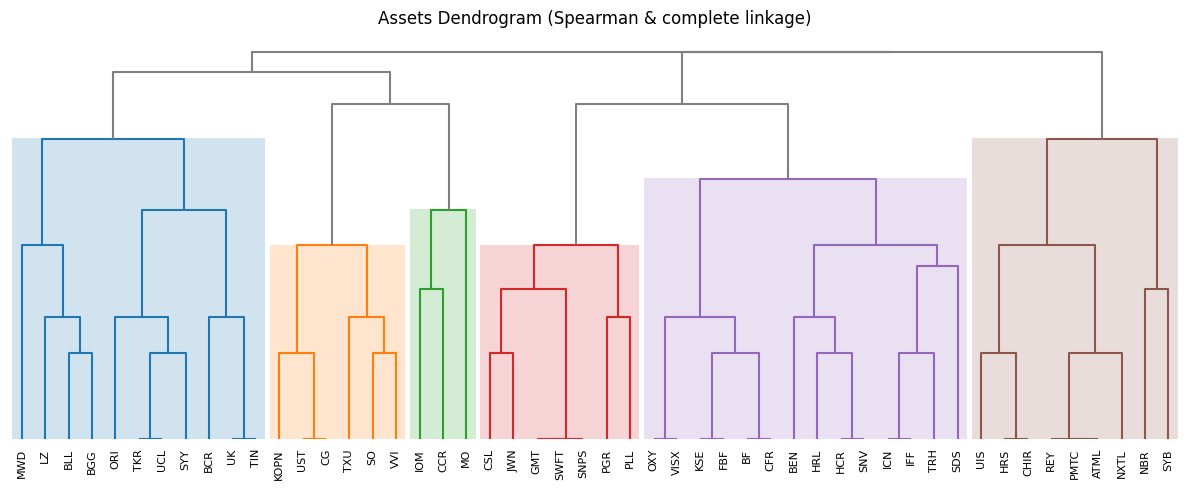

In [173]:
import riskfolio as rp

# Plotting Assets Clusters

import riskfolio as rp

# Supposons que ton DataFrame s'appelle 'new_dataframe'
# et qu'il contient les retours des actifs
returns = new_dataframe

# Sélectionner aléatoirement 50 actions parmi les 200
selected_stocks = returns.sample(n=50, axis=1, random_state=42)

# Step 3: Estimate the optimal portfolio
model = 'HRP'  # Could be HRP or HERC
codependence = 'spearman'  # Correlation matrix used to group assets in clusters
rm = 'MV'  # Risk measure used, this time will be variance
rf = 0  # Risk-free rate
linkage = 'complete'  # Linkage method used to build clusters
max_k = 10  # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True  # Consider optimal order of leaves in dendrogram
# Créer le dendrogramme
ax = rp.plot_dendrogram(returns=selected_stocks,
                        codependence=codependence,
                        linkage=linkage,
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)


In [174]:
# Building the portfolio object
port = rp.HCPortfolio(returns=selected_stocks)

# Step 2: Calculate and fix the covariance matrix using Ledoit-Wolf shrinkage
from sklearn.covariance import LedoitWolf
lw = LedoitWolf()
cov_matrix_shrinked = lw.fit(selected_stocks).covariance_

# Set the shrunk covariance matrix directly in the portfolio object
port.cov_matrix = cov_matrix_shrinked

# Apply the optimization
w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

# Display the optimized weights
display(w.T)


,OXY,CSL,ATML,SNV,SYY,KOPN,KSE,VVI,SO,HRL,...,TRH,HRS,MO,UST,BF,UCL,PGR,IFF,SNPS,UK
weights,0.006548,0.098251,0.01236,0.017184,0.02159,0.004866,0.002261,0.026768,0.013136,0.014967,...,0.06359,0.023761,0.053744,0.088973,0.010161,0.013404,0.006943,0.038268,0.008442,0.017623


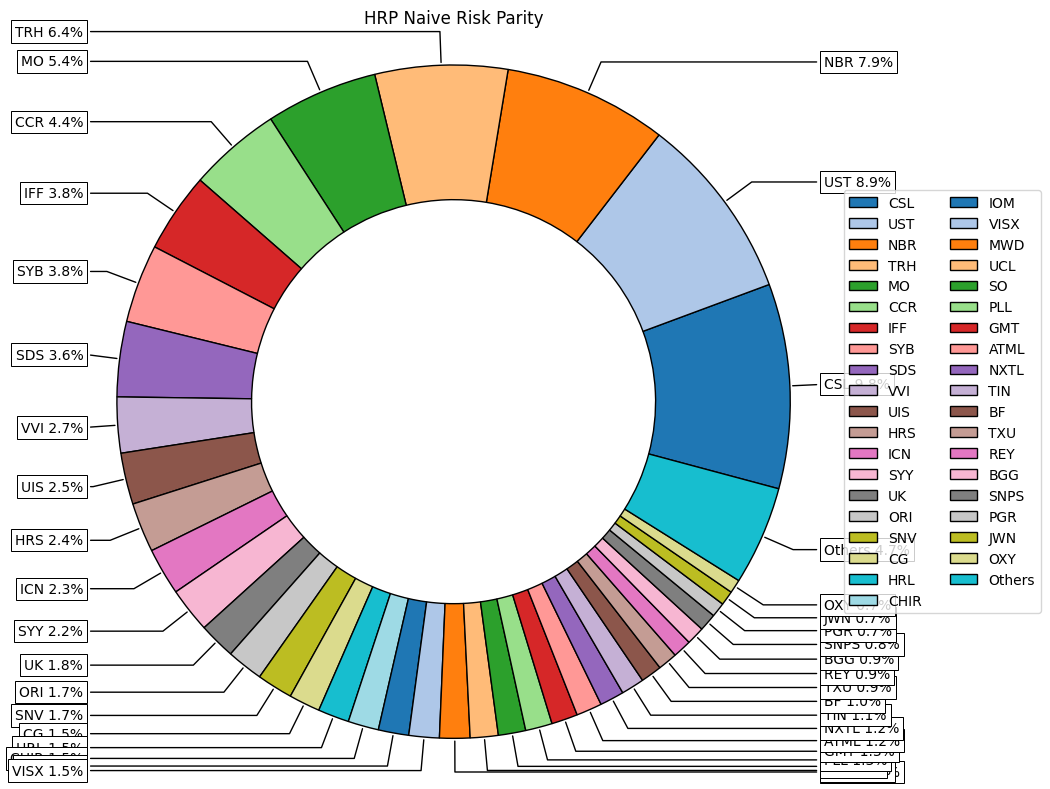

In [176]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

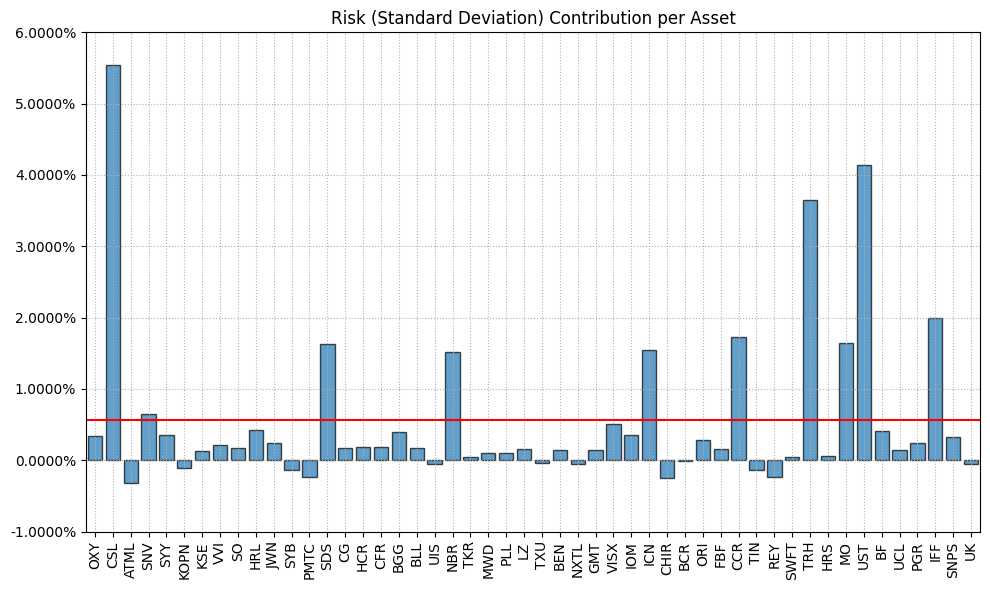

In [177]:
# Plotting the risk contribution per asset

mu = selected_stocks.mean()
cov = cov_matrix_shrinked # Covariance matrix
returns = selected_stocks # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=12,
                      ax=None)

In [151]:
from sklearn.covariance import LedoitWolf

# Apply Ledoit-Wolf shrinkage to the covariance matrix
lw = LedoitWolf()
cov_matrix_shrinked = lw.fit(selected_stocks).covariance_

# Now use the shrinked covariance matrix in your calculations


---

In [152]:
import numpy as np

# Check if the covariance matrix is positive semi-definite
eigvals = np.linalg.eigvals(cov_matrix_shrinked)

# Display eigenvalues
print(eigvals)

# Check for negative eigenvalues
if np.any(eigvals < 0):
    print("The covariance matrix is not positive semi-definite.")
else:
    print("The covariance matrix is fine.")


[2.15628945+0.00000000e+00j 1.39694305+0.00000000e+00j
 0.63544879+0.00000000e+00j 1.10187503+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.12463866+0.00000000e+00j 0.12463866+0.00000000e+00j
 0.1246386

In [52]:
ticker_data = data
ticker_data["date"] = ticker_data["date"].dt.strftime("%Y-%m")
ticker_train = ticker_data[(ticker_data["date"] >= "2000-01") & (ticker_data["date"] < "2010-01")].copy( )
ticker_test = ticker_data[(ticker_data["date"] >= "2010-01")].copy( )

In [53]:
ticker_data

,date,ret_eom,permno,shrcd,exchcd,mspread,year,month,size_port,rf,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety
0,2000-01,20000131,10078,11,3,0.017178,2000,1,B,0.0041,...,0.840323,0.424879,0.774368,0.765343,0.050000,-0.779141,0.985685,0.983871,0.899796,0.733871
1,2000-01,20000131,10104,11,3,0.019720,2000,1,B,0.0041,...,0.629032,0.717286,0.678700,0.942238,0.811290,-0.779141,0.349693,0.990323,-0.515337,0.359677
2,2000-01,20000131,10107,11,3,0.011369,2000,1,B,0.0041,...,0.645161,-0.920840,0.873646,0.465704,0.714516,-0.779141,0.588957,0.946774,-0.494888,0.882258
3,2000-01,20000131,10108,11,1,0.010600,2000,1,B,0.0041,...,-0.969355,0.668821,-0.209386,0.045126,-0.309677,-0.779141,0.695297,0.683871,0.014315,0.761290
4,2000-01,20000131,10119,11,1,0.003485,2000,1,B,0.0041,...,-0.617742,-0.859451,-0.510830,-0.812274,-0.911290,-0.668712,0.325153,-0.551613,0.989775,0.143548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225813,2020-03,20200331,21178,11,1,0.020627,2020,3,B,0.0013,...,-0.509677,-0.378641,0.255639,-0.699248,-0.574194,0.291139,0.781250,0.431373,0.590551,0.279221
225814,2020-03,20200331,21186,11,1,0.045519,2020,3,B,0.0013,...,0.800000,-0.262136,0.766917,0.857143,-0.045161,0.316456,-0.609375,-0.215686,-0.559055,-0.253247
225815,2020-03,20200331,21207,11,1,0.029221,2020,3,B,0.0013,...,-0.980645,-0.216828,-0.992481,-0.992481,0.838710,0.265823,0.789062,-0.235294,0.811024,0.766234
225816,2020-03,20200331,21371,11,1,0.028414,2020,3,B,0.0013,...,0.406452,0.126214,0.105263,0.075188,0.845161,-0.113924,-0.898438,-0.797386,-0.905512,-0.097403


In [54]:
X_train = ticker_train.drop(columns = ["stock_ticker", "stock_exret"]).set_index("date")
y_train = ticker_train["stock_exret"]

In [62]:
X_train

,ret_eom,permno,shrcd,exchcd,mspread,year,month,size_port,rf,cusip,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety
date,,,,,,,,,,,,,,,,,,,,,
2000-01,20000131,10078,11,3,0.017178,2000,1,B,0.0041,86681010,...,0.840323,0.424879,0.774368,0.765343,0.050000,-0.779141,0.985685,0.983871,0.899796,0.733871
2000-01,20000131,10104,11,3,0.019720,2000,1,B,0.0041,68389X10,...,0.629032,0.717286,0.678700,0.942238,0.811290,-0.779141,0.349693,0.990323,-0.515337,0.359677
2000-01,20000131,10107,11,3,0.011369,2000,1,B,0.0041,59491810,...,0.645161,-0.920840,0.873646,0.465704,0.714516,-0.779141,0.588957,0.946774,-0.494888,0.882258
2000-01,20000131,10108,11,1,0.010600,2000,1,B,0.0041,86736310,...,-0.969355,0.668821,-0.209386,0.045126,-0.309677,-0.779141,0.695297,0.683871,0.014315,0.761290
2000-01,20000131,10119,11,1,0.003485,2000,1,B,0.0041,90130N10,...,-0.617742,-0.859451,-0.510830,-0.812274,-0.911290,-0.668712,0.325153,-0.551613,0.989775,0.143548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12,20091231,92621,11,1,0.008426,2009,12,B,0.0001,46121Y10,...,0.700000,0.925000,0.000000,0.000000,0.236364,-0.956204,0.000000,0.640501,-0.001195,1.000000
2009-12,20091231,92655,11,1,0.006553,2009,12,B,0.0001,91324P10,...,-0.395455,0.315909,-0.613583,-0.189696,-0.422727,-0.562044,-0.255370,-0.003413,-0.751493,0.447727
2009-12,20091231,92697,11,1,0.004698,2009,12,B,0.0001,"5,26E+14",...,-0.804545,0.204545,0.000000,0.000000,-0.140909,-0.956204,0.000000,0.751991,-0.001195,-0.756818


In [69]:
# Select only columns with float data type
X_trainG = X_train.select_dtypes(include=['float64', 'float32'])

# Drop rows with NaN values
X_trainG = X_trainG.dropna()

y_train = y_train[X_trainG.index]
X_trainG

KeyError: "None of [Index(['2000-01', '2000-01', '2000-01', '2000-01', '2000-01', '2000-01',\n       '2000-01', '2000-01', '2000-01', '2000-01',\n       ...\n       '2009-12', '2009-12', '2009-12', '2009-12', '2009-12', '2009-12',\n       '2009-12', '2009-12', '2009-12', '2009-12'],\n      dtype='object', name='date', length=111798)] are in the [index]"

In [55]:
X_test = ticker_test.drop(columns = ["stock_ticker", "stock_exret"]).set_index("date")
y_test = ticker_test["stock_exret"]

In [56]:
def select_features(X, y, n_features = 50) :

    selector = SelectKBest(f_regression, k = n_features)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return selected_features

In [67]:
select_features(X_trainG, y_train, n_features = 50)

ValueError: Found input variables with inconsistent numbers of samples: [111798, 114393]